# Exploratory Data Analysis (EDA)

This notebook contains all EDA functions and analysis for the Rossmann Store Sales dataset.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

## Data Loading and Processing Functions

In [59]:
def load_data(data_dir='data'):
    """
    Load train, test, and store data from CSV files.
    
    Args:
        data_dir (str): Path to the data directory.
        
    Returns:
        tuple: (train_df, test_df, store_df)
    """
    train = pd.read_csv(os.path.join(data_dir, 'train.csv'), dtype={'StateHoliday': str})
    test = pd.read_csv(os.path.join(data_dir, 'test.csv'), dtype={'StateHoliday': str})
    store = pd.read_csv(os.path.join(data_dir, 'store.csv'))
    
    # Convert Date columns to datetime
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])
    
    return train, test, store

def merge_data(train, test, store):
    """
    Merge train and test data with store data.
    
    Args:
        train (pd.DataFrame): Training data.
        test (pd.DataFrame): Test data.
        store (pd.DataFrame): Store data.
        
    Returns:
        tuple: (train_merged, test_merged)
    """
    train_merged = pd.merge(train, store, on='Store', how='left')
    test_merged = pd.merge(test, store, on='Store', how='left')
    
    return train_merged, test_merged

def process_date(df, date_col='Date'):
    """
    Extract date features from a datetime column.
    
    Args:
        df (pd.DataFrame): Input dataframe.
        date_col (str): Name of the date column.
        
    Returns:
        pd.DataFrame: Dataframe with added date features.
    """
    df = df.copy()
    df['Year'] = df[date_col].dt.year
    df['Month'] = df[date_col].dt.month
    df['Day'] = df[date_col].dt.day
    df['DayOfWeek'] = df[date_col].dt.dayofweek + 1
    df['WeekOfYear'] = df[date_col].dt.isocalendar().week.astype(int)
    
    return df

## Utility Functions (Plotting)

In [60]:
def plot_target_distribution(df, target_col):
    """
    распределение таргета
    """
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[target_col], kde=True, bins=50)
    plt.title(f'{target_col} Distribution')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[target_col])
    plt.title(f'{target_col} Boxplot')
    
    plt.tight_layout()
    plt.show()

def plot_time_series(df, date_col, target_col, title):
    """
    агрегированный таргет по дате
    """
    daily_sales = df.groupby(date_col)[target_col].sum().reset_index()
    
    plt.figure(figsize=(15, 6))
    plt.plot(daily_sales[date_col], daily_sales[target_col])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.grid(True)
    plt.show()

## Общий анализ

In [61]:
# Load and Merge Data
train, test, store = load_data('data')
train_merged, test_merged = merge_data(train, test, store)

# Filter for training (Open stores and Sales > 0)
#train_merged = train_merged[(train_merged["Open"] != 0) & (train_merged['Sales'] > 0)]

# Process Date
train_merged = process_date(train_merged)

print("Train shape:", train_merged.shape)
train_merged.head()

Train shape: (1017209, 22)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


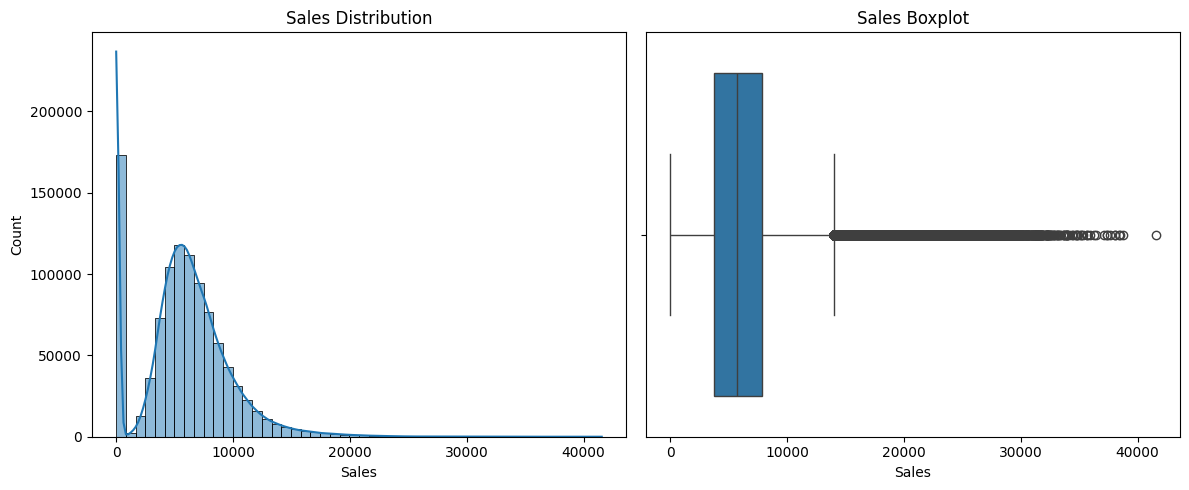

In [62]:
# Plot Target Distribution
plot_target_distribution(train_merged, 'Sales')

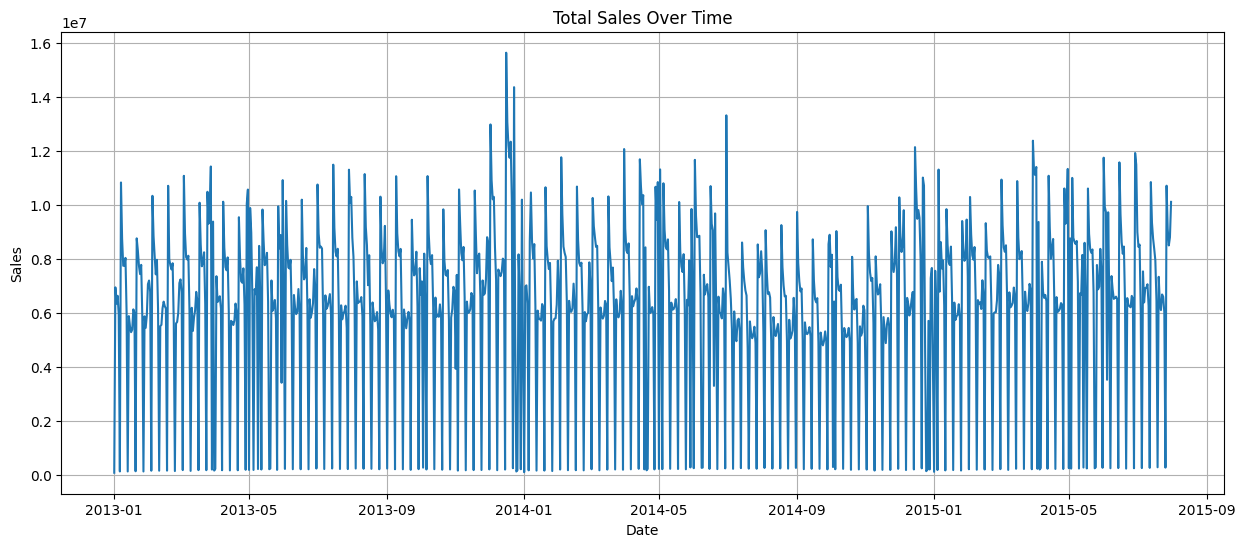

In [63]:
# Plot Time Series
plot_time_series(train_merged, 'Date', 'Sales', 'Total Sales Over Time')

## Pairplot

Columns for pairplot: ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year']


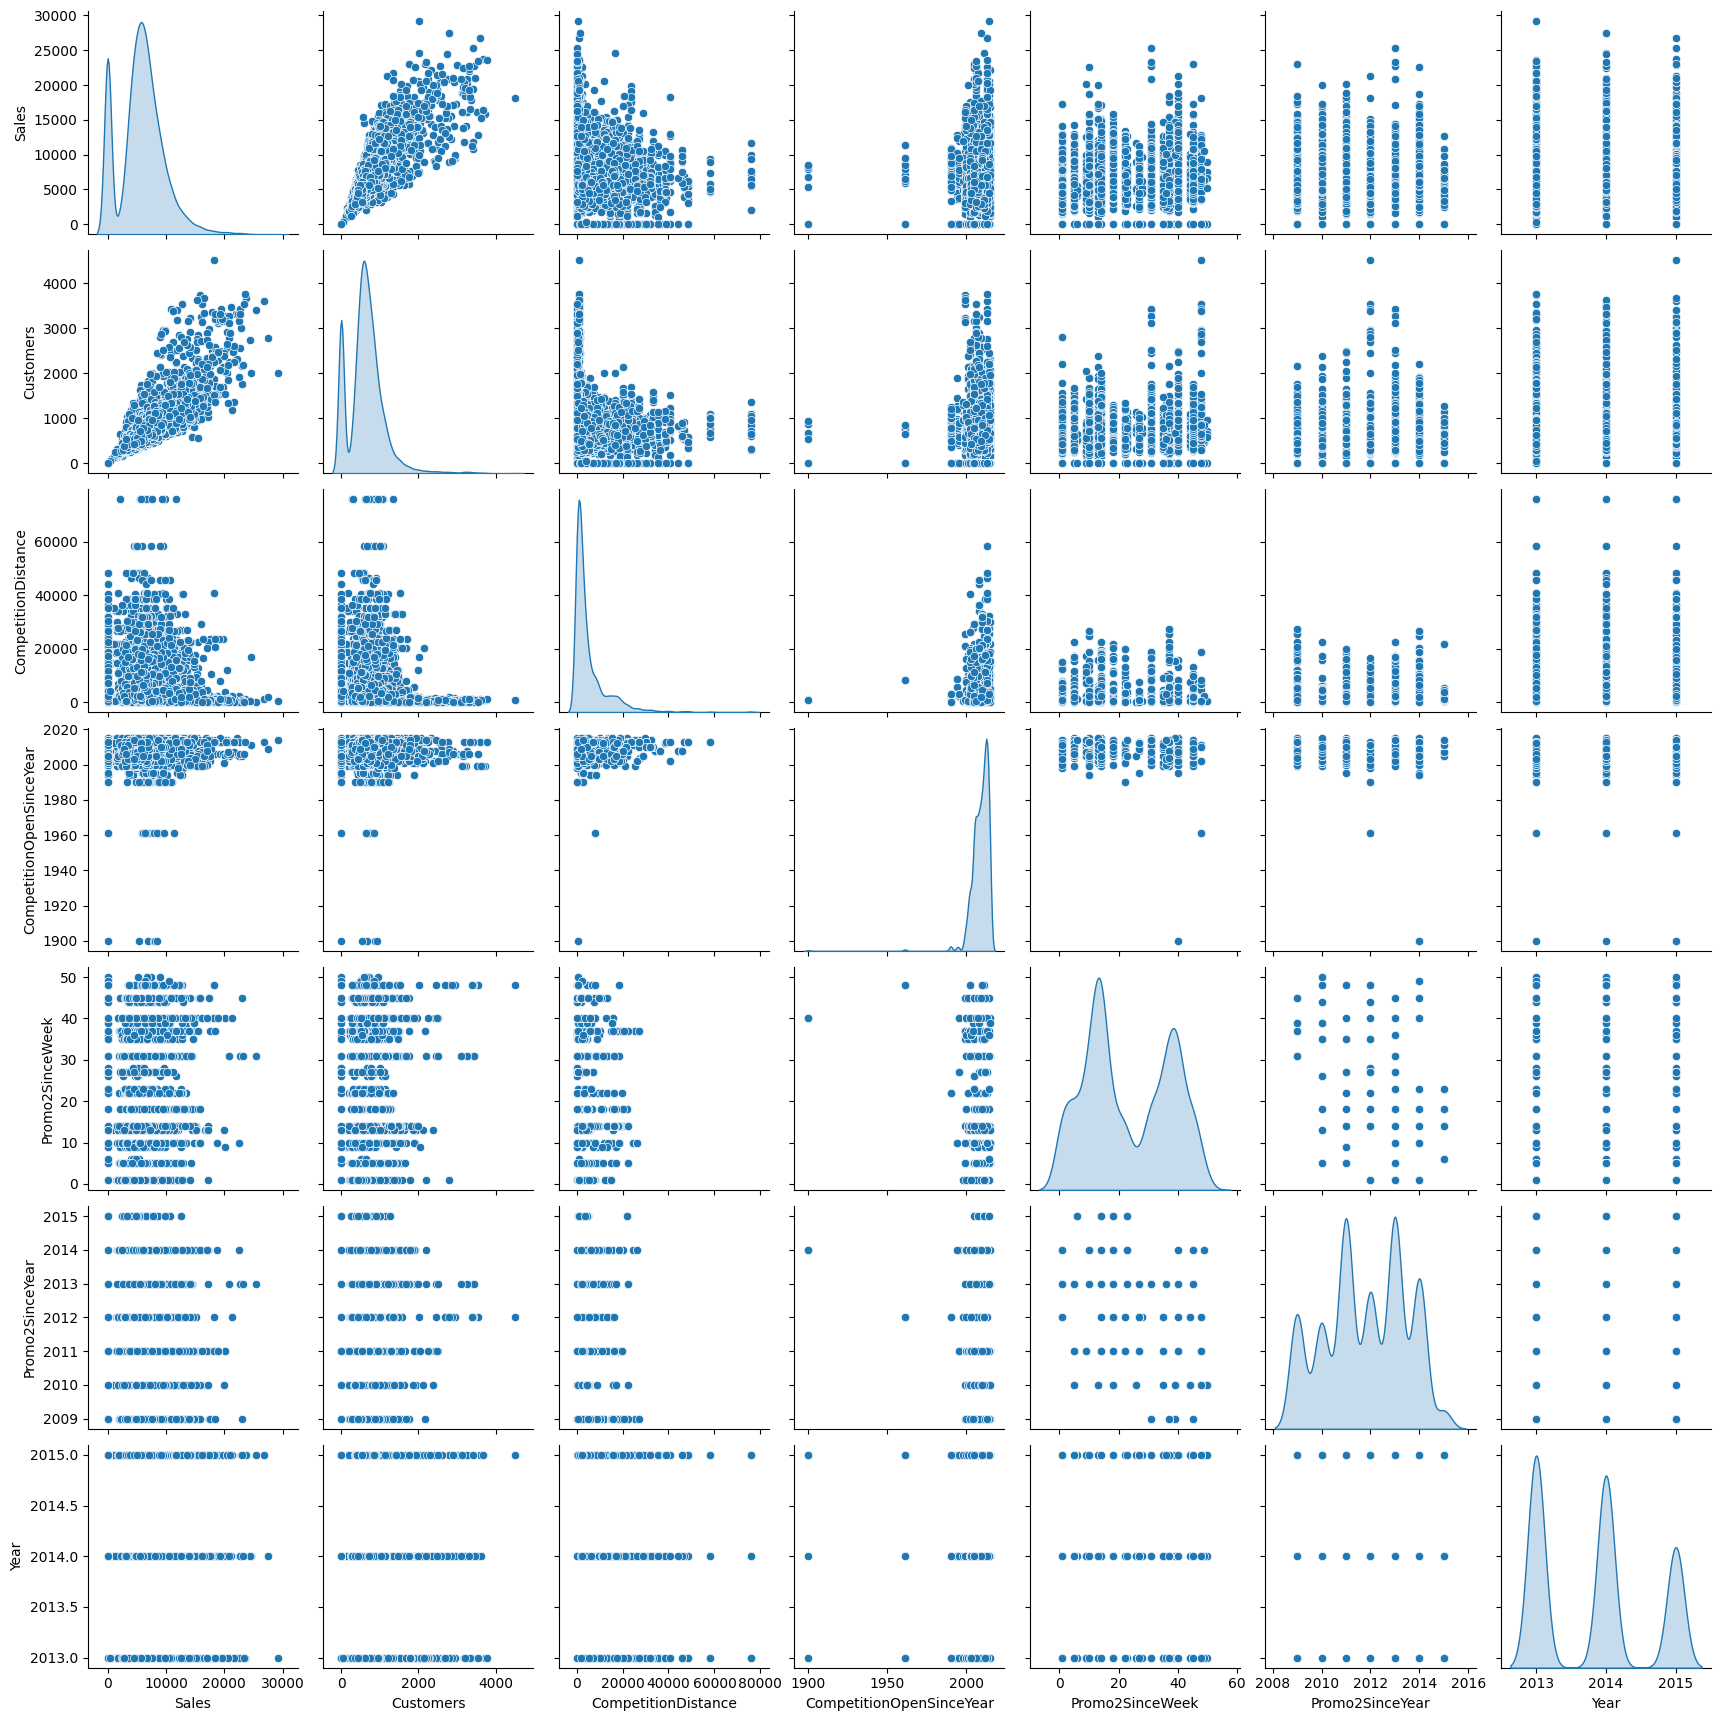

In [64]:
# Remove unnecessary features like 'Id'
cols_to_exclude = ['Id', 'Store', 'Date', 'SchoolHoliday', 'IsStateHoliday', 'Month', 'DayOfWeek', 'Open', 'Promo', 'Day', 
                   'WeekOfYear', 'CompetitionOpenSinceMonth', 'Promo2']

# Select numeric columns for pairplot
numeric_cols = train_merged.select_dtypes(include=[np.number]).columns.tolist()
pairplot_cols = [c for c in numeric_cols if c not in cols_to_exclude]

if 'Id' in pairplot_cols:
    pairplot_cols.remove('Id')

print("Columns for pairplot:", pairplot_cols)

sample_df = train_merged[pairplot_cols].sample(min(10000, len(train_merged)), random_state=42)

sns.pairplot(sample_df, diag_kind='kde')
plt.show()

In [65]:
# ohe = train_merged.PromoInterval.str.get_dummies(sep=',')
# ohe['promo_nan'] = train_merged.PromoInterval.isna().astype(int)
# ohe

## Анализ пропусков

In [66]:
# Подсчет пропущенных значений в каждом столбце
missing = train_merged.isnull().sum()
print("Пропущенные значения:\n", missing[missing > 0], sep="")

Пропущенные значения:
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


## Анализ категориальных признаков

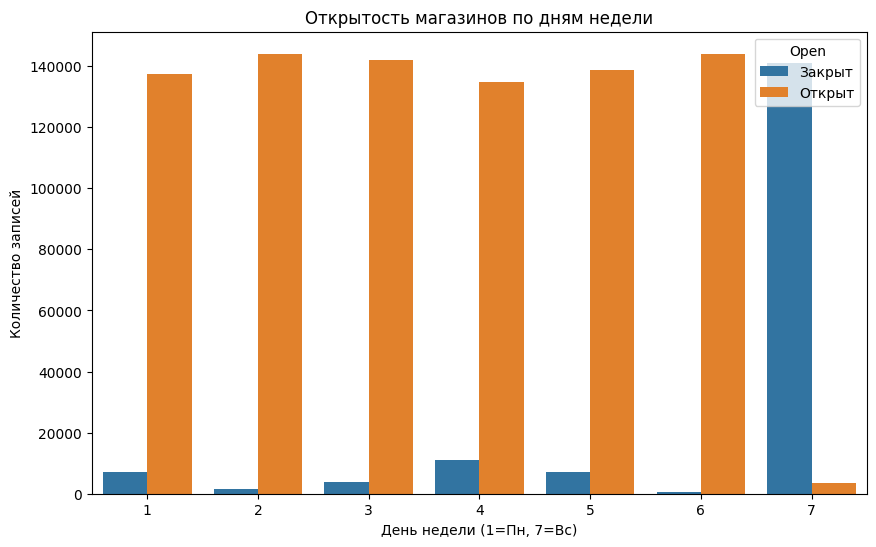

In [68]:
plt.figure(figsize=(10, 6))
open_by_dow = train_merged.groupby(['DayOfWeek', 'Open']).size().reset_index(name='Count')
open_by_dow['Open'] = open_by_dow['Open'].map({0: 'Закрыт', 1: 'Открыт'})

sns.barplot(x='DayOfWeek', y='Count', hue='Open', data=open_by_dow)
plt.title('Открытость магазинов по дням недели')
plt.xlabel('День недели (1=Пн, 7=Вс)')
plt.ylabel('Количество записей')
plt.show()

Чаще всего в воск

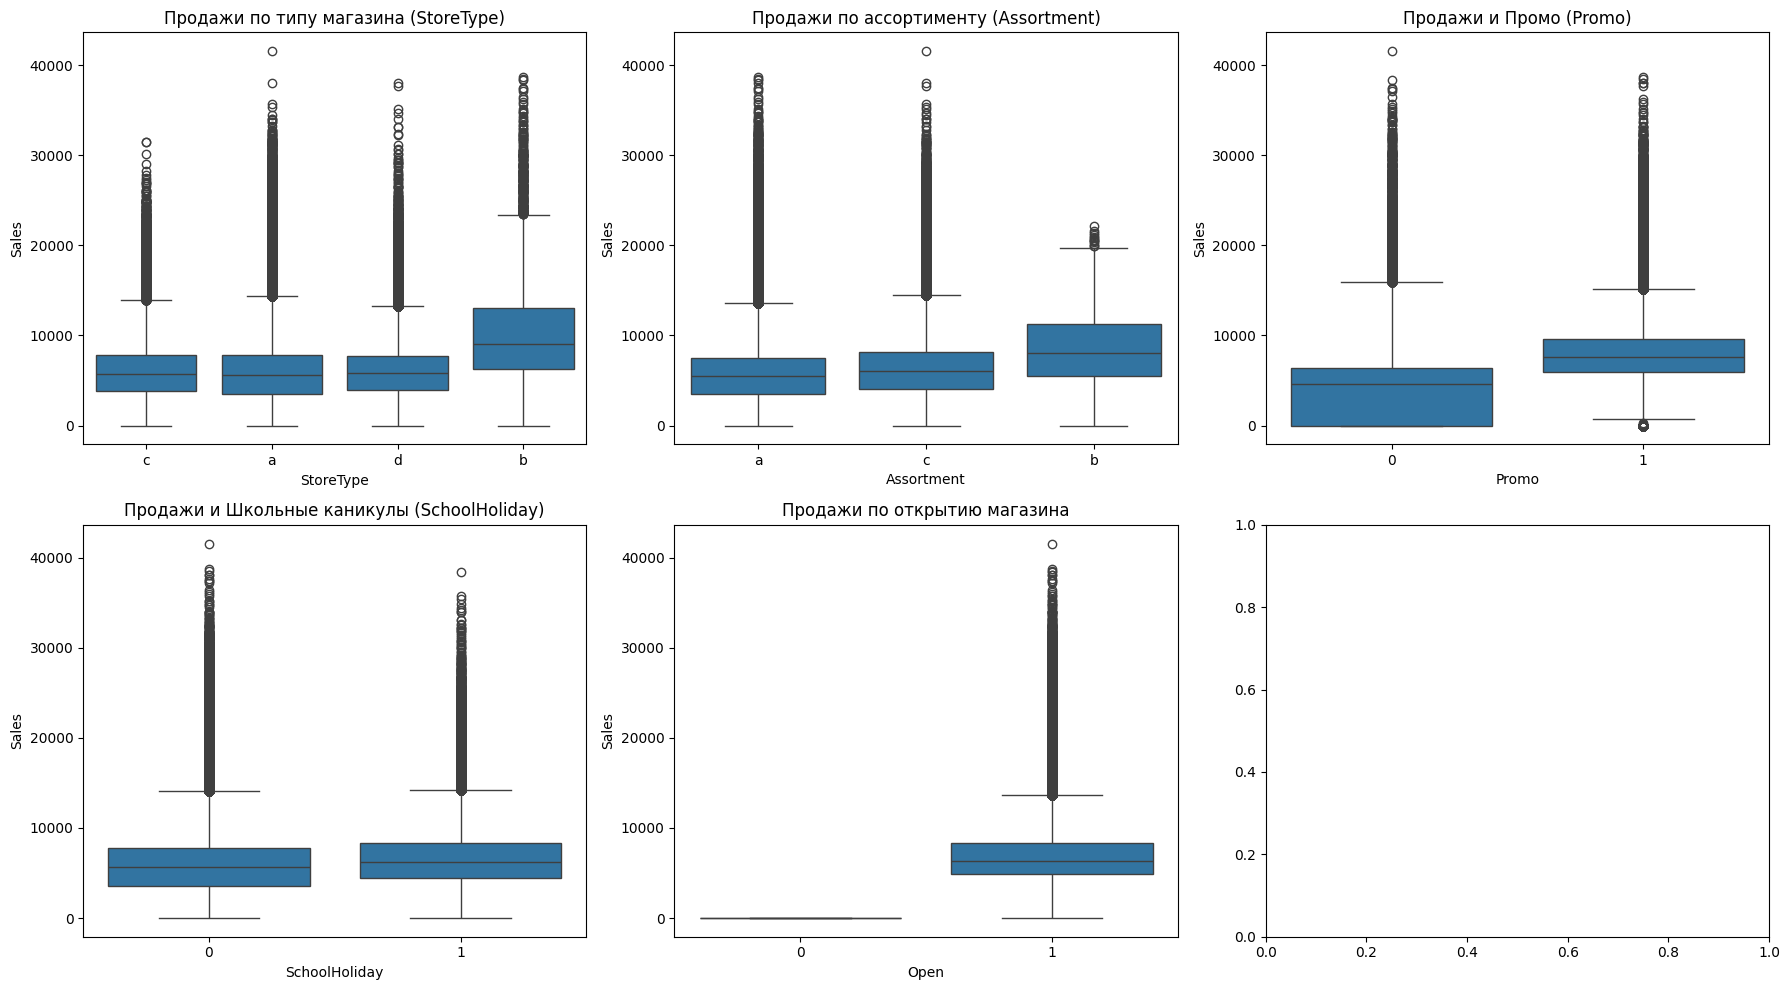

In [69]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.boxplot(x='StoreType', y='Sales', data=train_merged, ax=axes[0, 0])
axes[0, 0].set_title('Продажи по типу магазина (StoreType)')

sns.boxplot(x='Assortment', y='Sales', data=train_merged, ax=axes[0, 1])
axes[0, 1].set_title('Продажи по ассортименту (Assortment)')

sns.boxplot(x='Promo', y='Sales', data=train_merged, ax=axes[0, 2])
axes[0, 2].set_title('Продажи и Промо (Promo)')

sns.boxplot(x='SchoolHoliday', y='Sales', data=train_merged, ax=axes[1, 0])
axes[1, 0].set_title('Продажи и Школьные каникулы (SchoolHoliday)')

sns.boxplot(x='Open', y='Sales', data=train_merged, ax=axes[1, 1])
axes[1, 1].set_title('Продажи по открытию магазина')

plt.tight_layout()
plt.show()

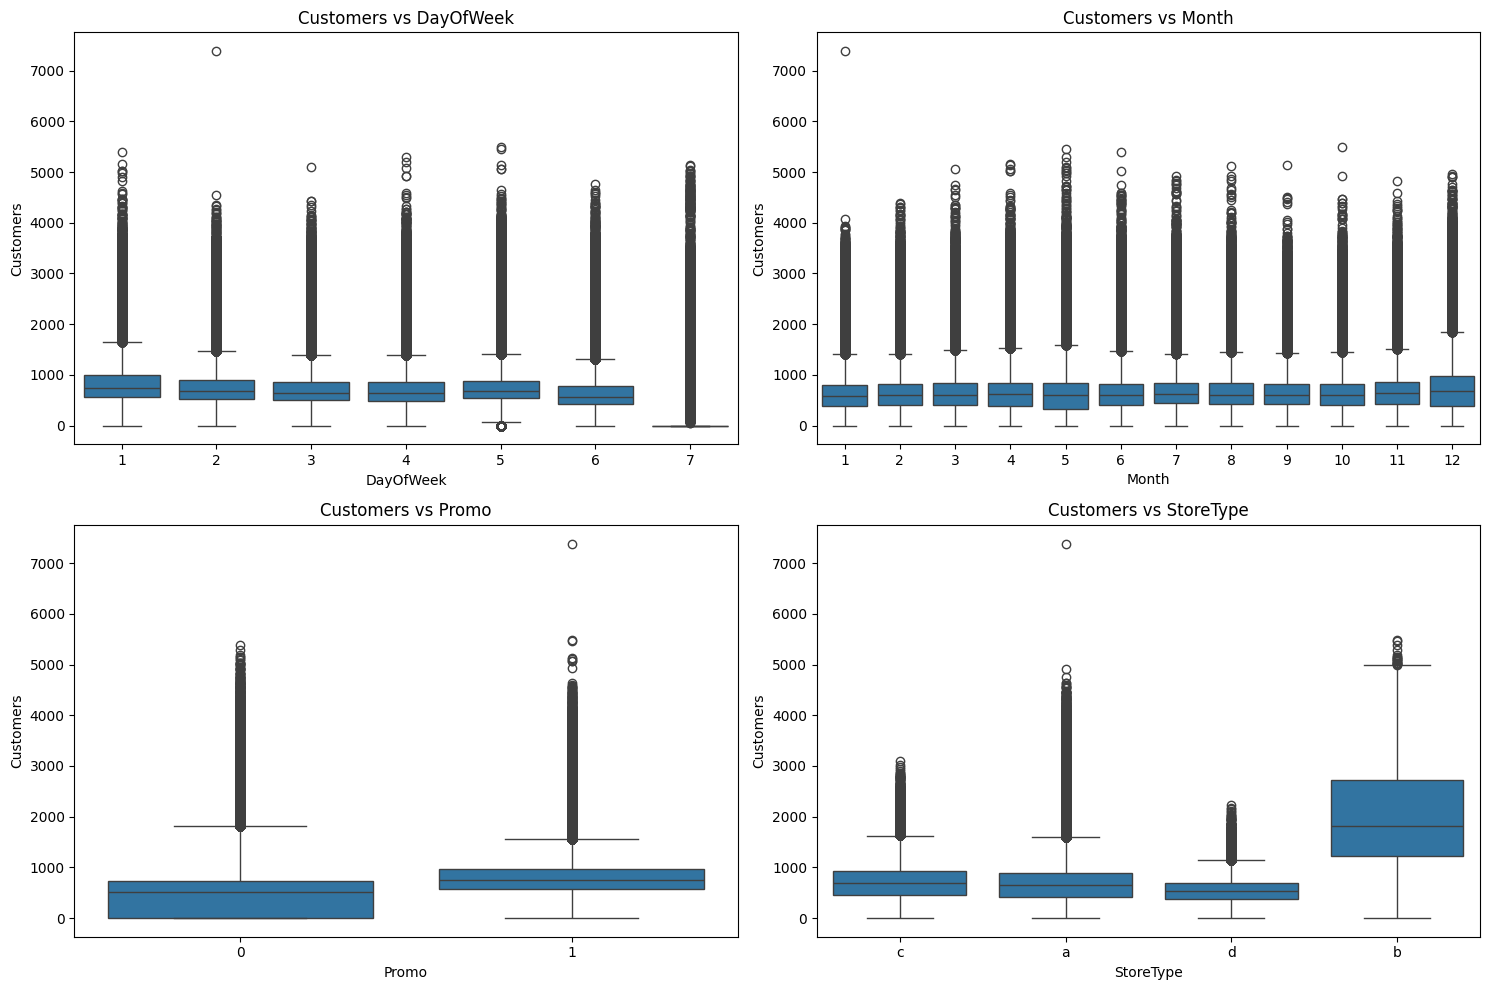

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(x='DayOfWeek', y='Customers', data=train_merged, ax=axes[0, 0])
axes[0, 0].set_title('Customers vs DayOfWeek')

sns.boxplot(x='Month', y='Customers', data=train_merged, ax=axes[0, 1])
axes[0, 1].set_title('Customers vs Month')

sns.boxplot(x='Promo', y='Customers', data=train_merged, ax=axes[1, 0])
axes[1, 0].set_title('Customers vs Promo')

sns.boxplot(x='StoreType', y='Customers', data=train_merged, ax=axes[1, 1])
axes[1, 1].set_title('Customers vs StoreType')

plt.tight_layout()
plt.show()

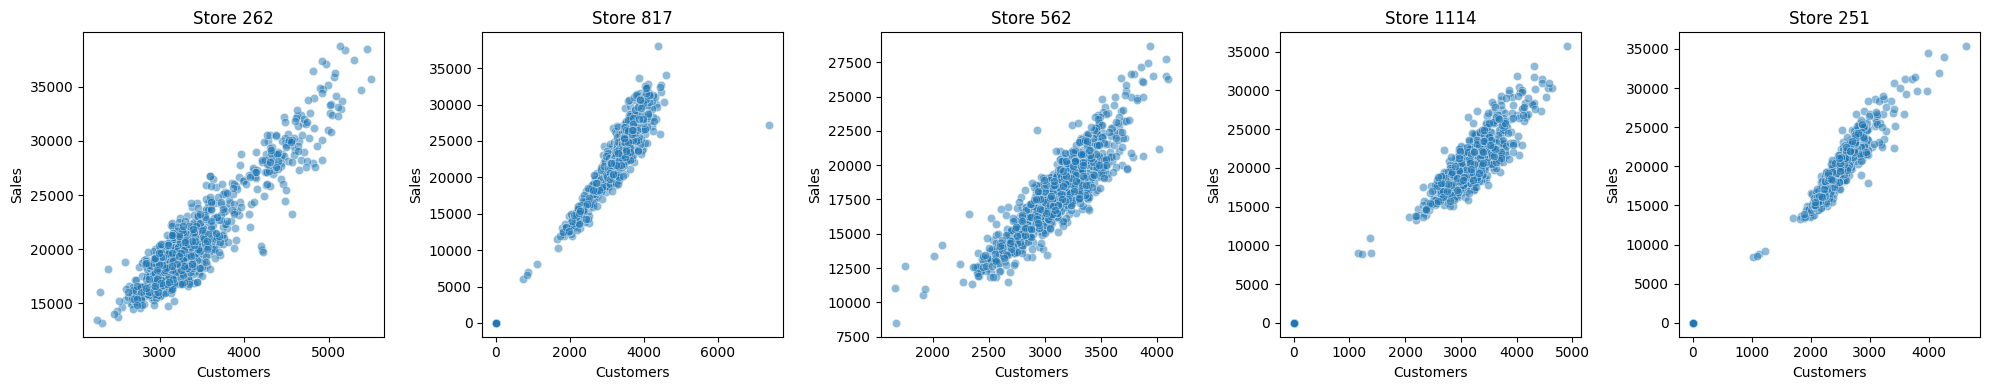

In [71]:
# Глянем на топ магазинов по продажам и их зависимость от кол-во клиентов
top5_stores = train_merged.groupby('Store')['Sales'].sum().nlargest(5).index

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, store in enumerate(top5_stores):
    store_data = train_merged[train_merged['Store'] == store]

    sns.scatterplot(
        data=store_data,
        x='Customers',
        y='Sales',
        alpha=0.5,
        ax=axes[idx]
    )

    axes[idx].set_title(f'Store {store}')
    axes[idx].set_xlabel('Customers')
    axes[idx].set_ylabel('Sales')

plt.tight_layout()
plt.show()


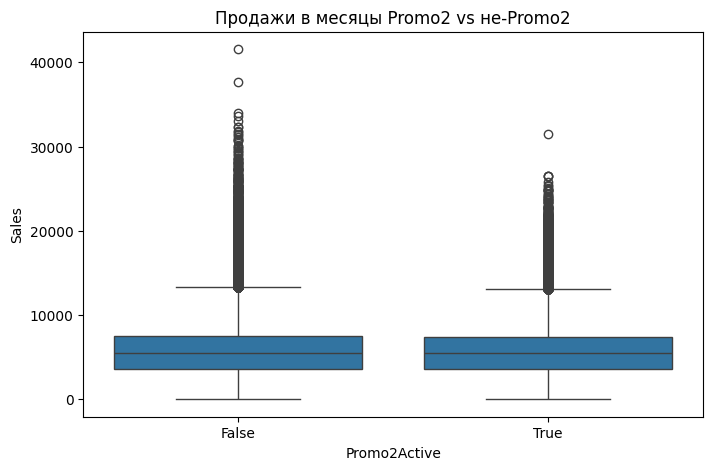

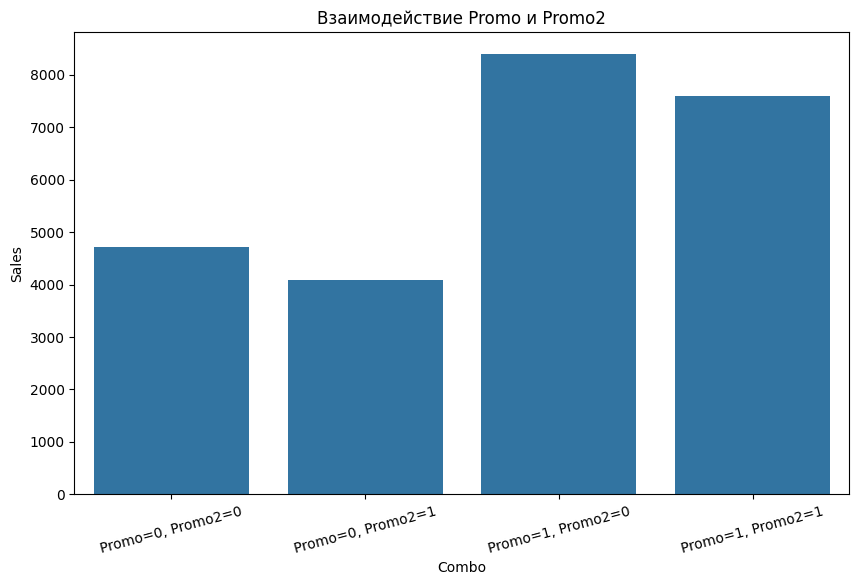

In [72]:
# Sales: Promo2 months vs non-Promo2 months
# Создаем признак активности Promo2
month_map = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
             'Jul':7,'Aug':8,'Sept':9,'Oct':10,'Nov':11,'Dec':12}

train_merged['Promo2Active'] = train_merged.apply(
    lambda x: (x['Promo2'] == 1 and 
               pd.notna(x['PromoInterval']) and
               x['Month'] in [month_map[m] for m in x['PromoInterval'].split(',')]),
    axis=1
)

plt.figure(figsize=(8, 5))
sns.boxplot(x='Promo2Active', y='Sales', data=train_merged[train_merged['Promo2']==1])
plt.title('Продажи в месяцы Promo2 vs не-Promo2')
plt.show()

# Взаимодействие Promo и Promo2
plt.figure(figsize=(10, 6))
interaction = train_merged.groupby(['Promo', 'Promo2'])['Sales'].mean().reset_index()
interaction['Combo'] = interaction.apply(
    lambda x: f"Promo={int(x['Promo'])}, Promo2={int(x['Promo2'])}", axis=1
)
sns.barplot(x='Combo', y='Sales', data=interaction)
plt.title('Взаимодействие Promo и Promo2')
plt.xticks(rotation=15)
plt.show()

Promo2 коррелирует с низкими продажами \
Предположения:

    1. Не Promo2 снижает продажи, а низкие продажи становятся причиной подключения Promo2
    Promo2 подключают в слабых магазинах для поддержки продаж

    2. Постоянные акции обесцениваются
    Клиенты ждут скидок и не покупают по полной цене

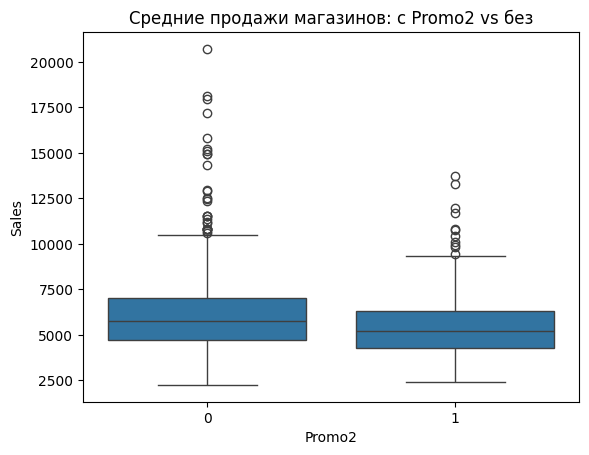

In [50]:
# Сравним характеристики магазинов с/без Promo2
store_stats = train_merged.groupby('Store').agg({
    'Sales': 'mean',
    'Promo2': 'first'
}).reset_index()

sns.boxplot(x='Promo2', y='Sales', data=store_stats)
plt.title('Средние продажи магазинов: с Promo2 vs без')
plt.show()

Проверили магазины с/без Promo2 на предмет продаж
Магазины с Promo2 изначально слабее

    Медиана продаж: Promo2=0 > Promo2=1
    Больше выбросов вверх у магазинов без Promo2
    Распределение у Promo2=1 смещено вниз

Вывод:
Promo2 - не причина, а следствие! Компания подключает долгосрочные акции к проблемным магазинам.

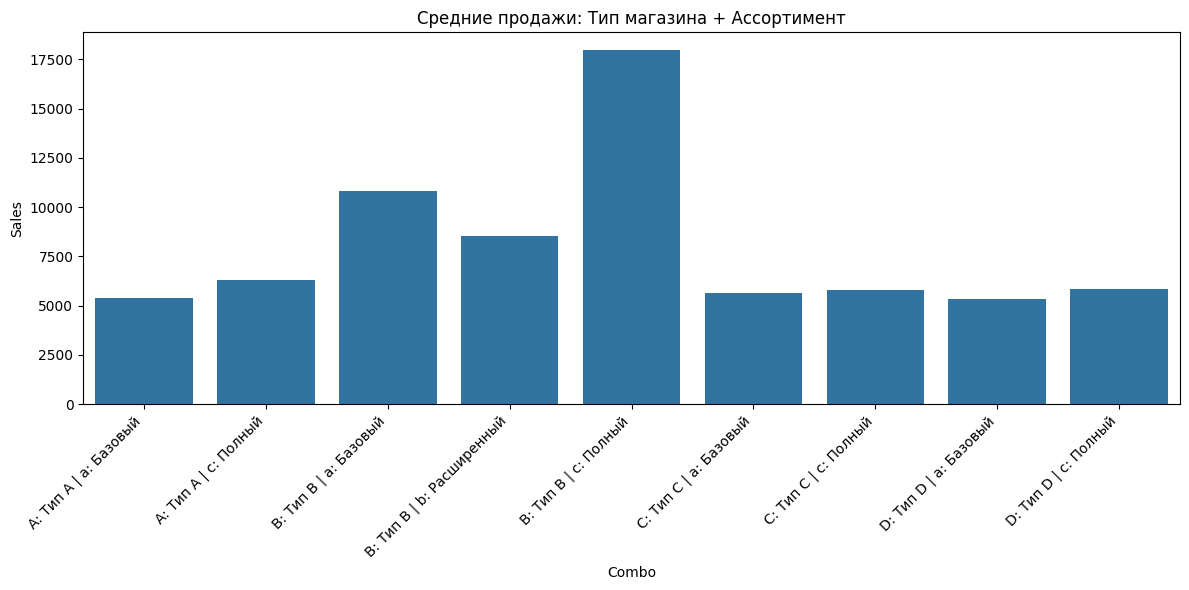

In [76]:
plt.figure(figsize=(12, 6))
combo_sales = train_merged.groupby(['StoreType', 'Assortment'])['Sales'].mean().reset_index()

store_names = {'a': 'A: Тип A', 'b': 'B: Тип B', 'c': 'C: Тип C', 'd': 'D: Тип D'}
assort_names = {'a': 'a: Базовый', 'b': 'b: Расширенный', 'c': 'c: Полный'}

combo_sales['Combo'] = (combo_sales['StoreType'].map(store_names) + ' | ' + 
                        combo_sales['Assortment'].map(assort_names))

sns.barplot(x='Combo', y='Sales', data=combo_sales)
plt.title('Средние продажи: Тип магазина + Ассортимент')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Анализ сезонности
Посмотрим, как продажи зависят от дня недели и месяца.

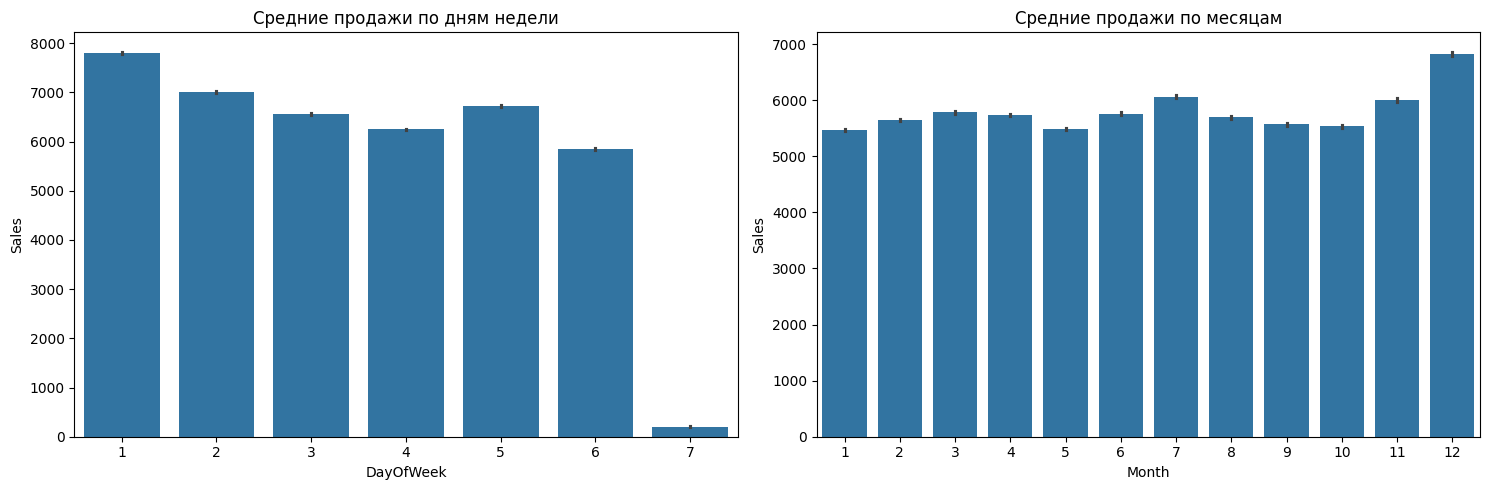

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Средние продажи по дням недели
sns.barplot(x='DayOfWeek', y='Sales', data=train_merged, ax=axes[0])
axes[0].set_title('Средние продажи по дням недели')

# Средние продажи по месяцам
sns.barplot(x='Month', y='Sales', data=train_merged, ax=axes[1])
axes[1].set_title('Средние продажи по месяцам')

plt.tight_layout()
plt.show()

Меньше всего покупают в воскресенье(так как большинство магазинов закрыты), а больше всего в понедельник и пятницу \
Топ месяцев: июль, ноябрь, декабрь \
Продажи явно сезонны по кварталам

## Корреляционный анализ
Построим тепловую карту корреляций для числовых признаков.

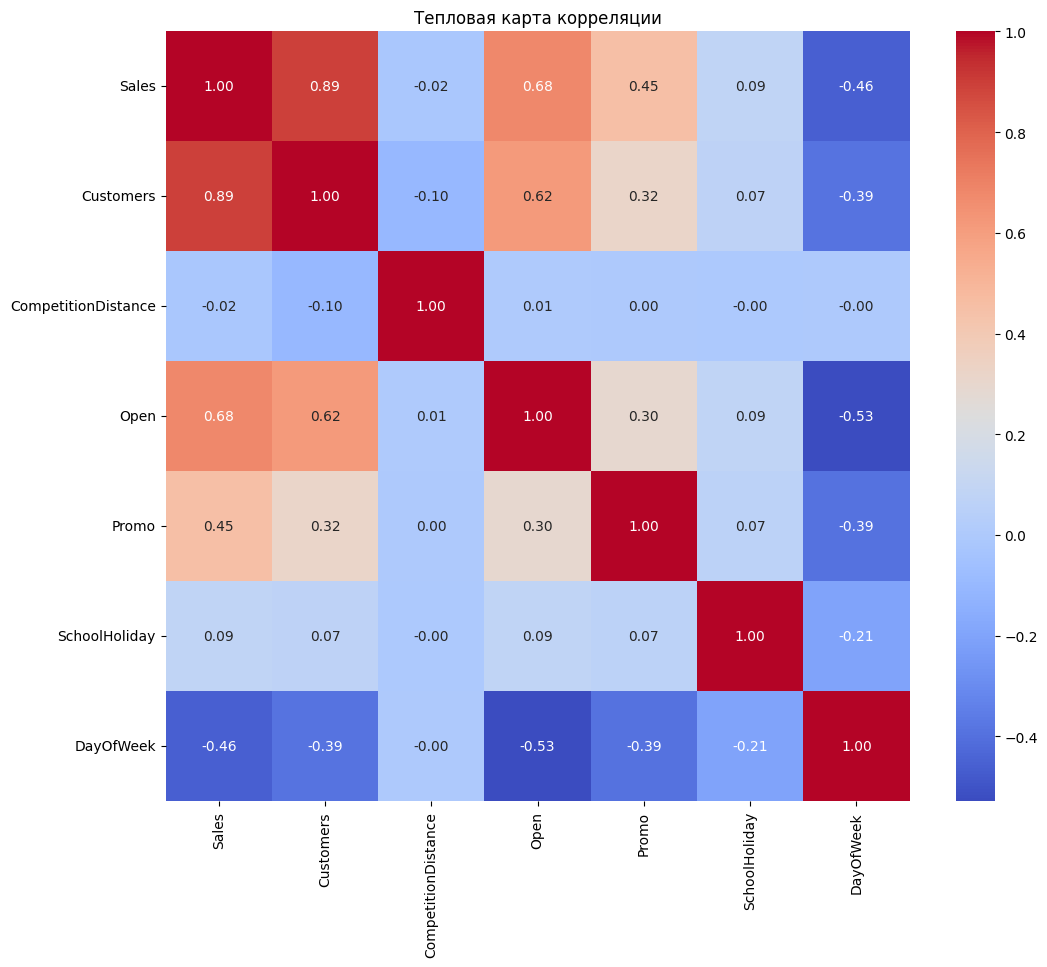

In [13]:
plt.figure(figsize=(12, 10))
numeric_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Open', 'Promo', 'SchoolHoliday', 'DayOfWeek', 'Month', 'Year']
# Оставляем только те столбцы, которые есть в датафрейме
numeric_cols = [c for c in numeric_cols if c in train_merged.columns]
corr = train_merged[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции')
plt.show()

Продажи сильно коррелируют с количеством покупателей \
Промо бустит продажи \
Отрицательная корреляция дня недели почти со всеми фичами объясняется очень низкими продажами в воскресенье(из-за того что магазы закрыты) 

## Анализ конкуренции и клиентов
Изучим взаимосвязь продаж с количеством клиентов и расстоянием до конкурентов.

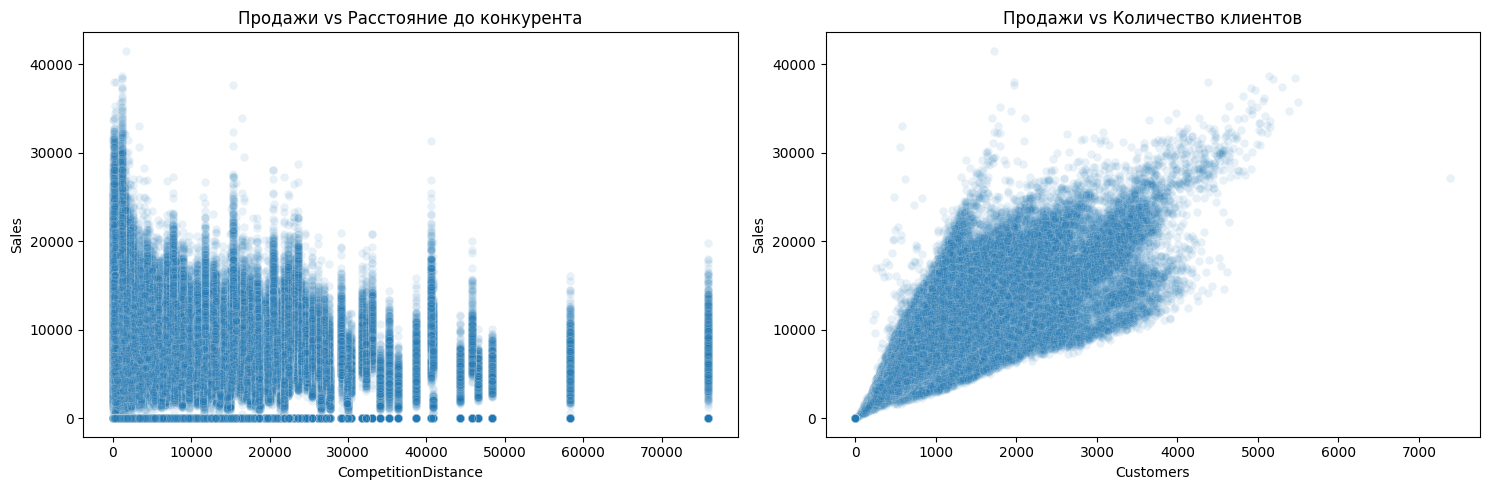

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Продажи vs Расстояние до конкурента
sns.scatterplot(x='CompetitionDistance', y='Sales', data=train_merged, alpha=0.1, ax=axes[0])
axes[0].set_title('Продажи vs Расстояние до конкурента')

# Продажи vs Количество клиентов
sns.scatterplot(x='Customers', y='Sales', data=train_merged, alpha=0.1, ax=axes[1])
axes[1].set_title('Продажи vs Количество клиентов')

plt.tight_layout()
plt.show()

### 1. Продажи формируются в первую очередь признаком Customers

Корреляция Sales~Customers = 0.89.
Scatter-плот показывает почти линейное облако.

Это главный факт: где больше покупателей, там больше выручка \
Именно трафик объясняет львиную долю вариации

### 2. Дни недели — сильнейший сезонный фактор

#### Проверено графиками:
* Понедельник — главный пик продаж

* Вторник — второй по силе день

* Среда–четверг — низкая середина недели

* Пятница — сильный, но не пиковый день (ниже понедельника и вторника)

* Суббота — заментное падение

* Воскресенье — почти ноль, т.к. большинство магазинов закрыто

Главный итог: Недельный паттерн неравномерный. При выделении валидационной выборки важно делать срез по целым неделям, иначе распределение будет сильно смещено

### 3. По месяцам видна квартальная сезонность

Также есть интересные паттерны:
* Декабрь огромный лидер из-за новогоднего спроса
* Январь один из самых слабых месяцев
* Июль тоже топ месяц

### 4. Promo мощный фактор для продаж, а Promo2 почти бесполезен

#### Promo:

* сильный вертикальный сдвиг медианы продаж
* много высоких выбросов в дни Promo
* рост и Sales, и Customers

#### Promo2:

* медианы почти одинаковы с Promo2=0
* иногда даже чуть ниже
* реального эффекта на графиках не видно

Promo описываеткороткие акции, которые вызывают всплески продаж \
Promo2 описывает долгосрочные акции, да еще и вводится только для магазинов с худшими продажами, так что эффект размазанный

#### 5. StoreType b + Assortment b/c самые сильные связки магазинов по продажам

У Rossmann структура такая:

* a — маленькие базовые магазины
* b — крупные магазины с высокой проходимостью
* c — средние магазины
* d — маленькие точки у дома

#### Что показывают графики по фактам:

* StoreType b доминирует: самая высокая медиана продаж, самый широкий хвост и самое большое количество покупателей
* Но важный нюанс: самая сильная комбинация вообще — это StoreType b + Assortment c (полный ассортимент)
* При этом по отдельному признаку “Assortment” лидер — тип b, а не c (медиана у b выше). То есть ассортимент c хорош только когда магазин большой. В маленьких магазинах разницы между c и a почти нет


### 6. Открытие магазина (Open) почти определяющий фактор.

* При Open=0 почти всё равно 0.
* Open жёстко зависит от DayOfWeek (моного закрытых магазов по воскресеньям).

### 7. SchoolHoliday — почти ноль эффекта.

Ни boxplot, ни корреляции не показывают заметной зависимости:

* медианы почти одинаковые;
* хвосты идентичны.

Единственный возможный слабый эффект — очень незначительное повышение median

### 8. CompetitionDistance — линейно не влияет.

* корреляция почти нулевая;
* boxplot по Sales vs CompetitionDistance отсутствует выраженный тренд.

Влияние конкуренции либо нелинейное, либо зашумлённое